In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
torch.manual_seed(42)

# Step 1: Load preprocessed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
scaler = joblib.load('scaler.pkl')

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [5]:
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
features = ['PM2.5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'RH', 'WS', 'WD', 'BP', 'AT']
seq_length = 3
n_features = len(features)

# Step 2: Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_length, hidden_size)
        out = out[:, -1, :]    # Take last timestep
        out = self.fc(out)
        return out

In [46]:
hidden_size = 50
num_layers = 2
dropout = 0.2
model = LSTMModel(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

# Move to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")
print(model)

Using device: cuda
LSTMModel(
  (lstm): LSTM(13, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [47]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500
patience = 30
best_val_loss = float('inf')
early_stop_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'lstm_air_quality_pytorch.pt')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1/500, Train Loss: 0.095455, Val Loss: 0.160213
Epoch 2/500, Train Loss: 0.048331, Val Loss: 0.063629
Epoch 3/500, Train Loss: 0.043960, Val Loss: 0.091818
Epoch 4/500, Train Loss: 0.040013, Val Loss: 0.072568
Epoch 5/500, Train Loss: 0.033559, Val Loss: 0.061246
Epoch 6/500, Train Loss: 0.024740, Val Loss: 0.037446
Epoch 7/500, Train Loss: 0.023449, Val Loss: 0.037453
Epoch 8/500, Train Loss: 0.018378, Val Loss: 0.036745
Epoch 9/500, Train Loss: 0.016826, Val Loss: 0.035947
Epoch 10/500, Train Loss: 0.016388, Val Loss: 0.034914
Epoch 11/500, Train Loss: 0.016103, Val Loss: 0.036121
Epoch 12/500, Train Loss: 0.016585, Val Loss: 0.037856
Epoch 13/500, Train Loss: 0.016054, Val Loss: 0.034921
Epoch 14/500, Train Loss: 0.015636, Val Loss: 0.033174
Epoch 15/500, Train Loss: 0.014974, Val Loss: 0.041146
Epoch 16/500, Train Loss: 0.014666, Val Loss: 0.033117
Epoch 17/500, Train Loss: 0.014367, Val Loss: 0.034639
Epoch 18/500, Train Loss: 0.014104, Val Loss: 0.032196
Epoch 19/500, Train

In [48]:
model.load_state_dict(torch.load('lstm_air_quality_pytorch.pt'))
model.eval()

C:\Users\gauth\AppData\Local\Temp\ipykernel_6136\2707023848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_air_quality_pytorch.pt

LSTMModel(
  (lstm): LSTM(13, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [49]:
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [50]:
pm25_scaler = MinMaxScaler()
pm25_scaler.min_ = scaler.min_[0]  # PM2.5 is first column
pm25_scaler.scale_ = scaler.scale_[0]

In [51]:
y_test_unscaled = pm25_scaler.inverse_transform(y_true.reshape(-1, 1))
y_pred_unscaled = pm25_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"Test RMSE: {rmse:.2f} µg/m³")
print(f"Test MAE: {mae:.2f} µg/m³")

Test RMSE: 13.37 µg/m³
Test MAE: 10.82 µg/m³


In [59]:
r2 = r2_score(y_true, y_pred)
r2

-1.2938635349273682

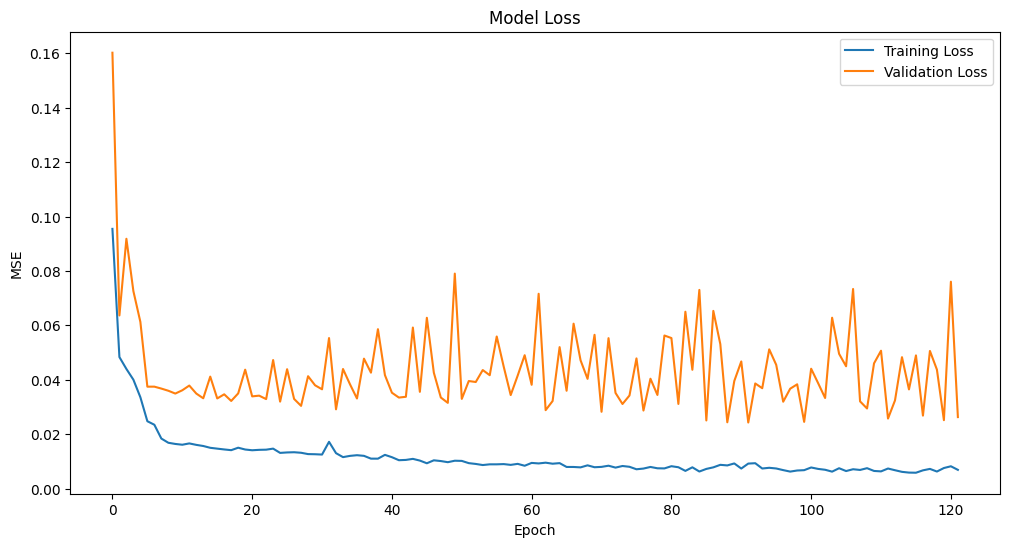

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.savefig('training_loss_pytorch.png')
plt.close()

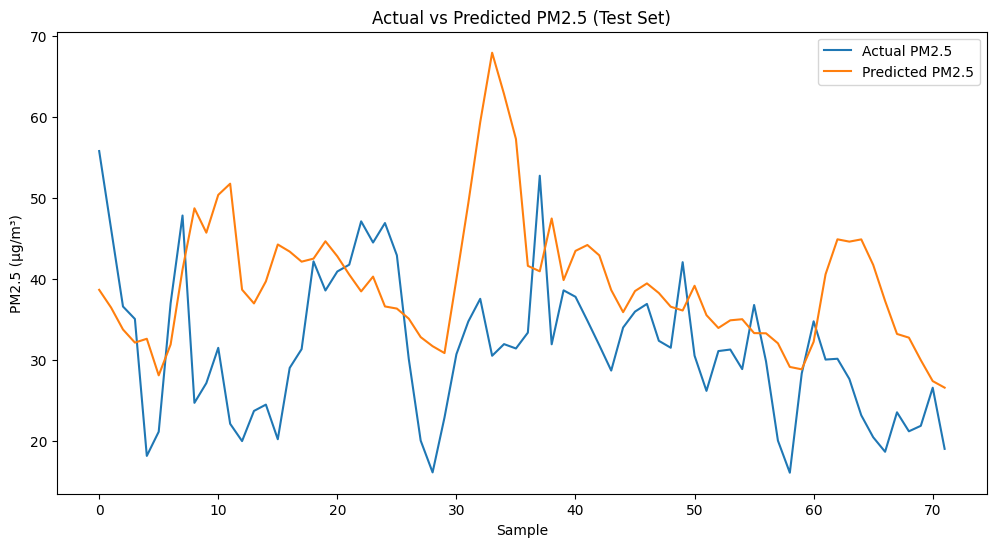

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual PM2.5')
plt.plot(y_pred_unscaled, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Test Set)')
plt.xlabel('Sample')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
plt.savefig('actual_vs_predicted_pytorch.png')
plt.close()